Linear Kernel Accuracy: 0.956140350877193
RBF Kernel Accuracy: 0.9736842105263158

Classification Report (RBF Kernel):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



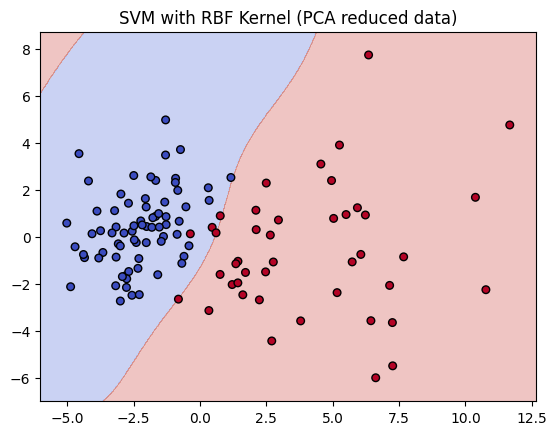

Best Parameters from GridSearchCV: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Score: 0.9736263736263737
Cross-validation scores: [0.97368421 0.95614035 1.         0.96491228 0.97345133]
Mean CV accuracy: 0.9736376339077782


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Load dataset
df = pd.read_csv("archive/breast-cancer.csv")

# Drop ID column if exists
if "id" in df.columns:
    df.drop(columns=["id"], inplace=True)

# Encode target column (diagnosis: B=0, M=1)
if "diagnosis" in df.columns:
    le = LabelEncoder()
    df["diagnosis"] = le.fit_transform(df["diagnosis"])  

# Split features & target
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 2. Train SVM models
svm_linear = SVC(kernel="linear", C=1)
svm_rbf = SVC(kernel="rbf", C=1, gamma="scale")

svm_linear.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)

# Evaluate
print("Linear Kernel Accuracy:", accuracy_score(y_test, svm_linear.predict(X_test)))
print("RBF Kernel Accuracy:", accuracy_score(y_test, svm_rbf.predict(X_test)))

print("\nClassification Report (RBF Kernel):\n", classification_report(y_test, svm_rbf.predict(X_test)))

# 3. Visualize decision boundaries using PCA (2D reduction)
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_scaled)

X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
    X_vis, y, test_size=0.2, random_state=42
)

# Train SVM on 2D data
svm_rbf_vis = SVC(kernel="rbf", C=1, gamma="scale")
svm_rbf_vis.fit(X_train_vis, y_train_vis)

# Plot decision boundary
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.coolwarm, edgecolors="k")
    plt.title(title)
    plt.show()

plot_decision_boundary(svm_rbf_vis, X_test_vis, y_test_vis, "SVM with RBF Kernel (PCA reduced data)")

# 4. Hyperparameter tuning with GridSearchCV
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", 0.01, 0.001, 0.0001],
    "kernel": ["rbf"]
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters from GridSearchCV:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

# 5. Cross-validation evaluation
cv_scores = cross_val_score(SVC(kernel="rbf", C=grid.best_params_["C"], gamma=grid.best_params_["gamma"]),
                            X_scaled, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())
